# Clasificador Naive Bayes

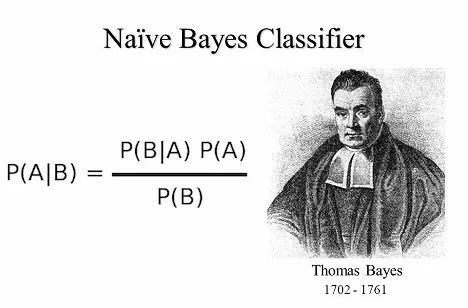

En aprendizaje automático y ciencia de datos, *Naïve Bayes* es un algoritmo simple pero ampliamente utilizado. Este es un algoritmo clasificador basado en **probabilidad**. La base de este modelo es el teorema de Bayes:

$P(C \mid x) = \frac{P(x \mid C) \cdot P(C) }{ P(x) }$


Donde,

* $P(C \mid x)$: Probabilidad posterior de ocurrencia del evento (clase) $C$, dada la observación $x$
* $P(x \mid C)$: Probabilidad de observar $x$ si $C$ es verdad
* $P(C)$: Probabilidad de observar $C$
* $P(x)$: Probabilidad de observar $x$


En pocas palabras, el clasificador *Naïve Bayes* clasifica una instancia calculando el **posterior** de cada clase, dada la instancia; $P(C \mid x)$, asignando la predicción a la clase con el mayor posterior. En la práctica, la probabilidad posterior puede ser complicada de calcular, por lo tanto se hacen algunas (arriegadas) suposiciones, de ahí el nombre: **Naïve** *Bayes*.

Para adquirir mayor conocimiento de como funciona, puedes ver los siguientes vídeos:
* [Multinomial Naive Bayes](https://www.youtube.com/watch?v=O2L2Uv9pdDA) para probabilidades discretas
* [Gaussian Naive Bayes](https://www.youtube.com/watch?v=H3EjCKtlVog) para probabilidades continuas

## Carga y preparación de datos
Utilizaremos el famoso conjunto de datos de *iris*. Comenzaremos por dividir los datos en conjuntos de *entrenamiento* (70%) y *prueba* (30%).

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("iris.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal length  150 non-null    float64
 1   sepal width   150 non-null    float64
 2   petal length  150 non-null    float64
 3   petal width   150 non-null    float64
 4   class         150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [ ]:
train = df.sample(frac = 0.7, random_state = 1)
test = df.drop(train.index)

y_train = train["class"]
x_train = train.drop("class", axis = 1)

y_test = test["class"]
x_test = test.drop("class", axis = 1)
print('Dimensiones de datos de prueba', x_test.shape,'\nDimensiones de datos de entrenamiento', x_train.shape)

Dimensiones de datos de prueba (45, 4) 
Dimensiones de datos de entrenamiento (105, 4)


## Entrenamiento del modelo
Entrenar un modelo de Naïve Bayes es muy simple. Pero antes de llegar allí, debemos establecer la distribución en la que basamos las probabilidades. Recordemos el Teorema de Bayes:

$P(C \mid x) = \frac{P(x \mid C) \cdot P(C) }{ P(x) }$


Donde,

* $P(C \mid x)$: Probabilidad posterior de ocurrencia del evento (clase) $C$, dada la observación $x$
* $P(x \mid C)$: Probabilidad de observar $x$ si $C$ es verdad
* $P(C)$: Probabilidad de observar $C$
* $P(x)$: Probabilidad de observar $x$

Para encontrar las probabilidades *a posteriori* $P(C \mid x)$, necesitamos calcular la probabilidad $P(x \mid C)$ y el *a priori* $P(C)$.

Podemos obtener esta probabilidad si conocemos la distribución de $x$. Comunmente se asume una distribución gaussiana (normal) para todas las clases, ya que es una buena aproximación para muchas otras distribuciones.

La distribución normal requiere dos parámetros: $\mu$ y $\sigma^2$. Dado que no conocemos los valores reales de estos parámetros debemos estimarlos a partir de las muestras actuales.

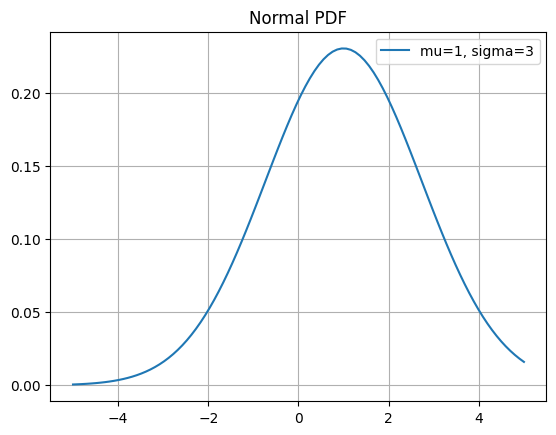

In [ ]:
import matplotlib.pyplot as plt

def normalpdf(n, mu=0, sigma=1):
    # Funcion para estimar PDF (Probability Density Function) dado que hay una distribucion Normal(mu, var) evaluado con x
    sd = np.sqrt(sigma)
    pdf = (np.e ** (-0.5 * ((n - mu)/sd) ** 2)) / (sd * np.sqrt(2 * np.pi))
    return pdf


# Define the parameters of the Gaussian function
mu = 1  # mean
sigma = 3  # standard deviation

xs = np.linspace(-5, 5, 100)
ys = normalpdf(xs, mu, sigma)

# Generate plot
plt.title('Normal PDF')
plt.plot(xs, ys, label = 'mu='+str(mu)+', sigma='+str(sigma))
plt.legend() # incluir label
plt.grid(True)
plt.show()

## Cálculo de probabilidad apriori
También necesitamos encontrar la probabilidad previa $P(C)$. Estimaremos la probabilidad previa de una clase $C$ contando todas las ocurrencias de la clase $C$ y dividiéndola por el número total de muestras.

También hay un $P(x)$ en la fórmula, que no necesita ser calculado. Llegaremos a la razón de esto más adelante.

IMPORTANTE: Todos estos calculos se realizan solo en los datos de entrenamiento.

In [ ]:
means = train.groupby(["class"]).mean() # Estimacion de la media de cada clase, por característica
var = train.groupby(["class"]).var() # Estimacion de la varianza de cada clase, por característica
prior = (train.groupby("class").count() / len(train)).iloc[:,1] # Estimacion probabilidades a priori P(C)
clases = np.unique(train["class"].tolist()) # Todas las clases posibles

print('Estimacion de la media de cada clase, por característica:\n', means)
print('\nEstimacion de la varianza de cada clase, por característica\n', var)
print('\nEstimacion probabilidades a priori\n', prior)

Estimacion de la media de cada clase, por característica:
                  sepal length  sepal width  petal length  petal width
class                                                                
Iris-setosa          5.084848     3.493939      1.457576     0.248485
Iris-versicolor      5.925714     2.785714      4.268571     1.325714
Iris-virginica       6.718919     2.989189      5.632432     2.056757

Estimacion de la varianza de cada clase, por característica
                  sepal length  sepal width  petal length  petal width
class                                                                
Iris-setosa          0.132576     0.176212      0.024394     0.010076
Iris-versicolor      0.234319     0.085378      0.196924     0.033143
Iris-virginica       0.366577     0.116547      0.337808     0.060856

Estimacion probabilidades a priori
 class
Iris-setosa        0.314286
Iris-versicolor    0.333333
Iris-virginica     0.352381
Name: sepal width, dtype: float64


Ahora tenemos todo lo que necesitamos para calcular la probabilidad posterior $P(C\mid x)$. Con esto concluye el proceso de entrenamiento.

$ $

# Clasificación
El proceso de clasificación en un clasificador (Gaussian) **Naïve Bayes** se realiza calculando el *posterior* para todas las clases dados los datos actuales.
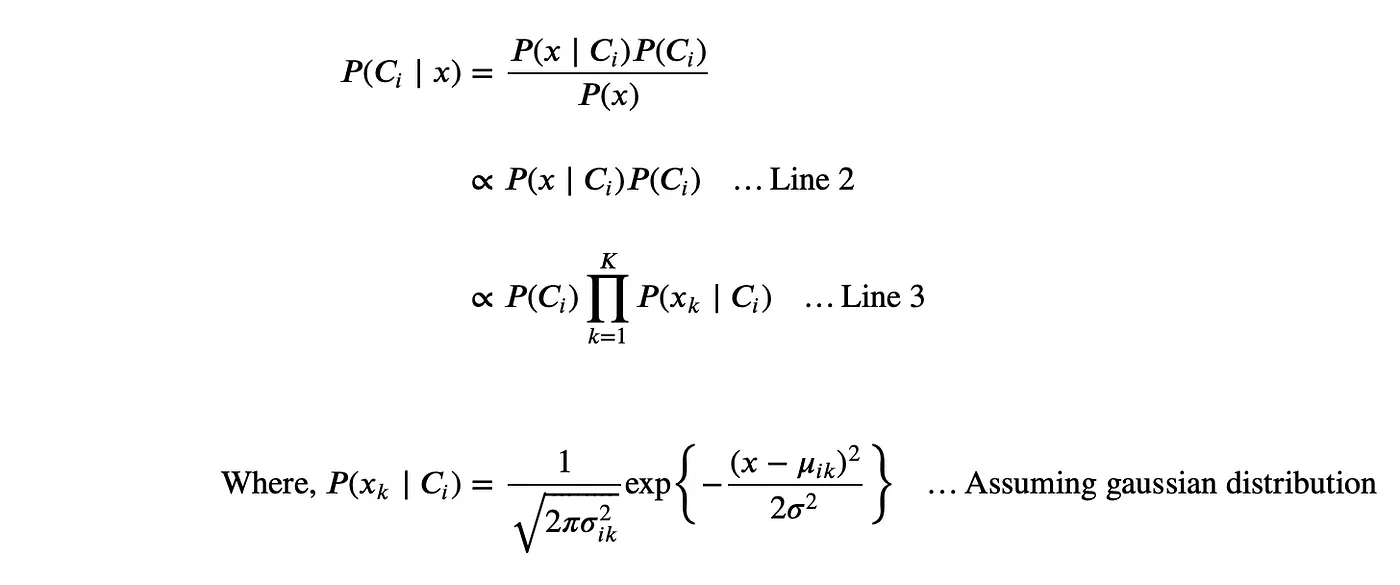

Nota: $\propto$ es aquí un símbolo que se lee como "proporcional a".

Algunos comentarios:
1. Línea 2: se "deshecha" $P(x)$. Esto se debe a que la probabilidad de observar $x$ es la misma en todas las clases. Esto no afectará el cálculo porque no necesitamos encontrar la probabilidad posterior real de las clases. En cambio, solo necesitamos ver qué clase tiene la mayor probabilidad posterior. Dividir todas las probabilidades posteriores por la misma constante devolvería los mismos resultados sobre cuál es el valor más grande.
2. Línea 3: $P(x \mid C)$ se expande para denotar todas las dimensiones (columnas) de cada patrón (vector). La expresión inicial $P(x \mid C)$ es la probabilidad de observar $x$ (i.e., la fila completa), dada la clase actual ($C_i$). Esta versión ampliada calcula la probabilidad de cada característica (columna) del patrón (fila) y clase $C_i$ (datos individuales) asumiendo una distribución normal.

## El "problema" con Naive Bayes
Si estás familiarizado con probabilidades, puede que notes algo falaz en la expansión de la línea 3. Aquí está el desglose de la misma:

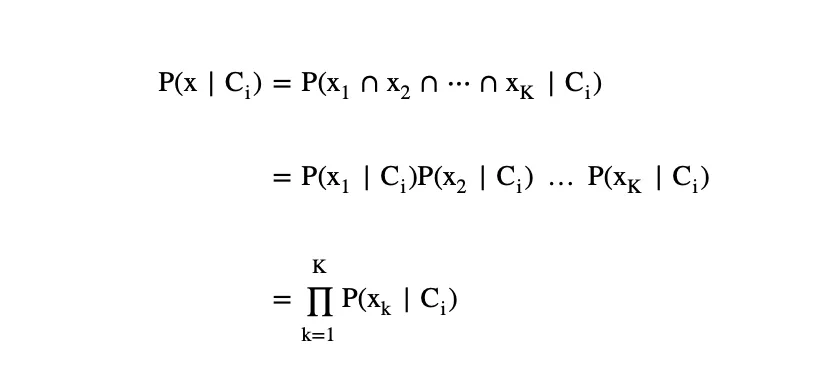

He aquí donde muchos entusiastas de las matemáticas y estadística pueden "levantar la ceja" o exclamar...

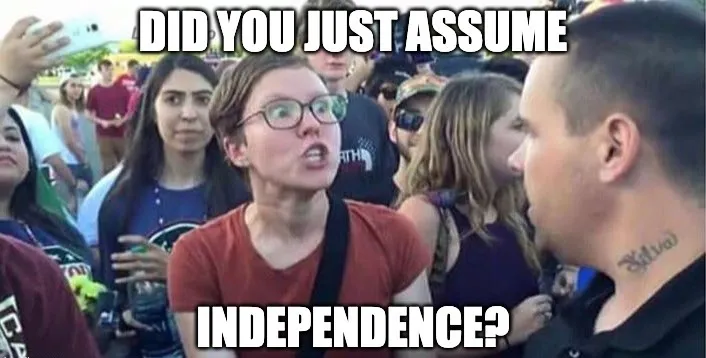

Esta es una suposición esencial del modelo Naive Bayes: asumir que todas las características son independientes entre sí. En práctica esto no sucede a menudo (y de ahí su nombre *Naive* Bayes) pero ha funcionado muy bien y por tanto, ha alcanzado una gran aceptación en la comunidad de ML
 🙂.

## Ajuste logarítmico por Underflow
Volviendo al punto de clasificación, para calcular la probabilidad posterior $P(C_i\mid x)$ se suele sustituir la expresión original:

$P(C_i\mid x) \propto P(C_i)\prod_{k=1}^{K}P(x_k \mid C_i)$

por la siguiente expresión:


$\log P(C_i\mid x) \propto \log P(C_i) + \sum_{k=1}^{K} \log P(x_k \mid C_i)$


La razón de este cambio es realizar un ajuste para tomar en cuenta un problema potencial que puede suceder cuando se trabaja con cantidades muy "pequeñas" (e.g., probabilidades). En pocas palabras, al multiplicar cantidades pequeñas se puede tener como resultado valores demasiado pequeños para ser almacenados apropiadamente en memoria ([leer sobre Underflow](https://datascience.stackexchange.com/questions/80363/reduce-the-risk-of-numerical-underflow)).

Para mitigar este problema, el ajuste por desbordamiento toma el logaritmo de las probabilidades y realiza una suma en lugar de una multiplicación. Al trabajar con logaritmos, probabilidades "pequeñas" se transforman en valores más manejables, lo que reduce el riesgo de desbordamiento.

* Nota 1: Recuerda que $\log(ab)= \log a + \log b$
* Nota 2: También recuerda que $\exp(\log x) = x$

El proceso de clasificación de este modelo se realiza simplemente calculando la probabilidad *log-posterior* y observando qué clase obtiene el mayor valor.

El siguiente código muestra el proceso de clasificación:

In [ ]:
def predict(X):
    predictions = []

    for i in X.index: # Loop through each instances

        ClassLikelihood = []
        instance = X.loc[i]

        for cls in clases: # Loop through each class

            FeatureLikelihoods = []
            FeatureLikelihoods.append(np.log(prior[cls])) # Append log prior of class 'cls'

            for col in x_train.columns: # Loop through each feature

                data = instance[col]

                mean = means[col].loc[cls] # Find the mean of column 'col' that are in class 'cls'
                variance = var[col].loc[cls] # Find the variance of column 'col' that are in class 'cls'

                Likelihood = normalpdf(data, mean, variance)

                if Likelihood != 0:
                    Likelihood = np.log(Likelihood) # Find the log-likelihood evaluated at x
                else:
                    Likelihood = 1/len(train)

                FeatureLikelihoods.append(Likelihood)

            TotalLikelihood = sum(FeatureLikelihoods) # Calculate posterior
            ClassLikelihood.append(TotalLikelihood)

        MaxIndex = ClassLikelihood.index(max(ClassLikelihood)) # Find largest posterior position
        prediction = clases[MaxIndex]
        predictions.append(prediction)

    return predictions

En esta función ```predict(X)```, el *log-prior* ($\log P(C_i)$) se calcula en la línea 12 y las probabilidades logarítmicas $\log P(x_k\mid C_i)$ (independientes) se calculan en las líneas 21 y 24.

La probabilidad *log-posterior* de la clase dados los datos $\log P(C_i \mid x)$ se calcula sumando $\log P(C_i)$ y $\log P(x_k\mid C_i)$ en la línea 30.

Finalmente, se asigna la predicción de clase en las líneas 33 y 34 buscando el máximo valor *log-posterior*.

Para probar este modelo utilizaremos los conjuntos de entrenamiento y prueba y evaluaremos su precisión.



In [ ]:
PredictTrain = predict(x_train)
PredictTest = predict(x_test)

# Despliega su precisión
print('Training set Accuracy: ',round(100*sum(PredictTrain==y_train) / len(y_train),3),'%')
print('Testing set Accuracy: ',round(100*sum(PredictTest==y_test) / len(y_test),3),'%')

Training set Accuracy:  98.095 %
Testing set Accuracy:  91.111 %


# Implementación en SKLearn

Para utilizar `GaussianNB` en scikit-learn, primero necesitarás importar el módulo correspondiente:

```python
from sklearn.naive_bayes import GaussianNB
```

Luego, puedes crear una instancia del clasificador, ajustarlo a tus datos de entrenamiento y utilizarlo para hacer predicciones. Aquí tienes un ejemplo básico de cómo se podría usar:

```python
# Crear una instancia del clasificador
clf = GaussianNB()

# Ajustar el clasificador a los datos de entrenamiento
clf.fit(x_train, y_train)

# Hacer predicciones
predicciones = clf.predict(x_test)
```

# Conclusión
`GaussianNB` es útil cuando se pasan por alto las suposiciones de independencia condicional y distribución normal de las características, y puede ser una buena opción para problemas de clasificación con datos continuos.

Adaptado de [esta fuente](https://blog.devgenius.io/implementing-na%C3%AFve-bayes-classification-from-scratch-with-python-badd5a9be9c3).